# Use Pandas to Sort event arrivals csv files

##  Fei Zhang
### 2018-07-12

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
SOURCE_LATITUDE = 'source_latitude'
SOURCE_LONGITUDE = 'source_longitude'
STATION_LATITUDE = 'station_latitude'
STATION_LONGITUDE = 'station_longitude'
STATION_CODE = 'station_code'
FREQUENCY = 'no_of_summary_rays'

column_names = ['source_block', 'station_block',
                'residual', 'event_number',
                SOURCE_LONGITUDE, SOURCE_LATITUDE,
                'source_depth', STATION_LONGITUDE, STATION_LATITUDE,
                'observed_tt', 'locations2degrees', STATION_CODE, 'SNR', 'P_or_S']

def sort(output_file, sorted_file, residual_cutoff):
    """
    Sort and filter the arrivals.

    Sort based on the source and station block number.
    There are two stages of filtering:
    1. Filter based on the time residual
    2. Filter based on median of observed travel time.

    If there are multiple source and station block combinations, we keep the
    row corresponding to the median observed travel time (observed_tt).

    cmdline usage:
    cluster sort outfile_P.csv 5. -s sorted_P.csv
    cluster sort outfile_S.csv 10. -s sorted_S.csv


    :param output_file: output file from the gather stage (eg, outfile_P.csv)
    :param sorted_file: str, optional
        optional sorted output file path. Default: sorted.csv.
    :param residual_cutoff: float
        residual seconds above which arrivals are rejected.
    :return: None
    """

#     log.info('Filtering arrivals.')

    cluster_data = pd.read_csv(output_file, header=None,
                               names=column_names)
    
    cluster_data = cluster_data[abs(cluster_data['residual'])
                                < residual_cutoff]
    
    #cluster_data['source_depth'] = cluster_data['source_depth'] / 1000.0  # convert to KM?
    
    # groupby sorts by default
    # cluster_data.sort_values(by=['source_block', 'station_block'],
    #                          inplace=True)

#     log.info('Sorting arrivals.')

    # groupby automatically sorts
    med = cluster_data.groupby(by=['source_block',
                                   'station_block'])[
        'observed_tt'].quantile(q=.5, interpolation='lower').reset_index()

    final_df = pd.merge(cluster_data, med, how='right',
                        on=['source_block', 'station_block', 'observed_tt'],
                        sort=True,
                        right_index=True)

    # Confirmed: drop_duplicates required due to possibly duplicated picks in
    #  the original engdahl events
    # refer: https://github.com/GeoscienceAustralia/passive-seismic/issues/51
    # The subset is specified as we have some stations that are very close?
    final_df.drop_duplicates(subset=['source_block', 'station_block',
                                     'event_number', SOURCE_LONGITUDE,
                                     SOURCE_LATITUDE, 'source_depth'],
                             keep='first',
                             inplace=True)

    final_df.to_csv(sorted_file, header=False, index=False, sep=',')
    
    return final_df


In [3]:
!pwd


/g/data1a/ha3/fxz547/Githubz/passive-seismic/notebooks


In [4]:
inputcsv='/g/data1a/ha3/fxz547/travel_time_tomography/run5_events_1deg/outfile_S.csv'

residual_cutoff=10.0
sortedfile='sortedfile_S.csv'
sortedfile2= 'sortedfile2_S.csv'

inputcsv='/g/data/ha3/fxz547/Githubz/passive-seismic/seismic_events_arrivals_P_0.csv'
inputcsv='/g/data/ha3/fxz547/Githubz/passive-seismic/tempworks/outfile_P.csv'
residual_cutoff=5.0
sortedfile='sortedfile_P.csv'
sortedfile2= 'sortedfile2_P.csv'


In [5]:
finalpdf = sort(inputcsv,sortedfile,residual_cutoff)

In [6]:
finalpdf.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
28,543424,626937,-4.594806,7000,135.782,-4.301,4900.0,134.0455,-18.8731,205.740091,14.670456,BL06,7.199925,1
1324,543424,626937,-4.594806,171000,135.782,-4.301,4900.0,134.0455,-18.8731,205.740091,14.670456,BL06,7.199925,1
25,1378415,647095,0.050000,5000,83.516,30.839,10000.0,133.4898,-22.1527,680.498927,71.449337,BL11,4.268246,1
1355,1378415,647095,0.050000,177000,83.516,30.839,10000.0,133.4898,-22.1527,680.498927,71.449337,BL11,4.268246,1
1757,1401344,637018,0.950000,231000,55.814,26.804,12000.0,134.2961,-20.5914,777.797851,89.528001,BL08,4.523065,1


In [7]:
#sort again
pdf2=sort(sortedfile, sortedfile2, residual_cutoff )

In [8]:
pdf2.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
0,543424,626937,-4.594806,7000,135.782,-4.301,4900.0,134.0455,-18.8731,205.740091,14.670456,BL06,7.199925,1
1,543424,626937,-4.594806,171000,135.782,-4.301,4900.0,134.0455,-18.8731,205.740091,14.670456,BL06,7.199925,1
2,1378415,647095,0.050000,5000,83.516,30.839,10000.0,133.4898,-22.1527,680.498927,71.449337,BL11,4.268246,1
3,1378415,647095,0.050000,177000,83.516,30.839,10000.0,133.4898,-22.1527,680.498927,71.449337,BL11,4.268246,1
4,1401344,637018,0.950000,231000,55.814,26.804,12000.0,134.2961,-20.5914,777.797851,89.528001,BL08,4.523065,1


In [9]:
pdf2.shape

(1455, 14)

In [10]:
finalpdf.shape


(1455, 14)

<Figure size 432x288 with 0 Axes>

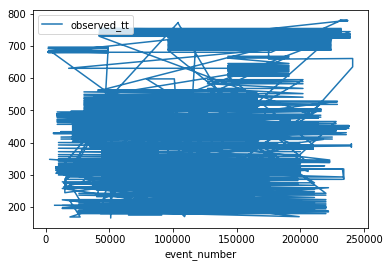

In [11]:
plt.figure(); pdf2.plot(x='event_number', y='observed_tt')
# plt.figure(); pdf2.plot(x='event_number', y='source_depth')
# plt.figure(); pdf2.plot(x='event_number', y='locations2degrees')
# plt.figure(); pdf2.plot(x='event_number', y='residual')  # less than +-10s



<Figure size 432x288 with 0 Axes>

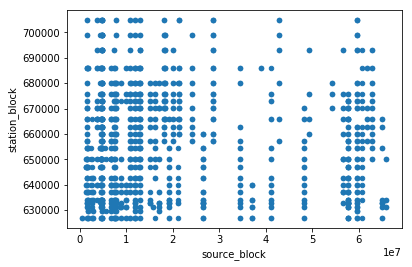

In [12]:
plt.figure(); pdf2.plot.scatter(x='source_block', y='station_block')

<Figure size 432x288 with 0 Axes>

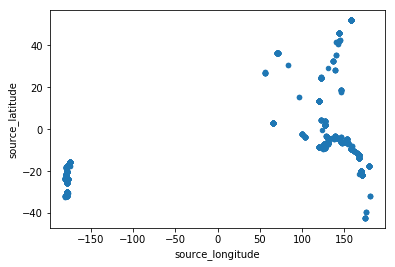

In [13]:
plt.figure(); pdf2.plot.scatter(x='source_longitude', y='source_latitude')

<Figure size 432x288 with 0 Axes>

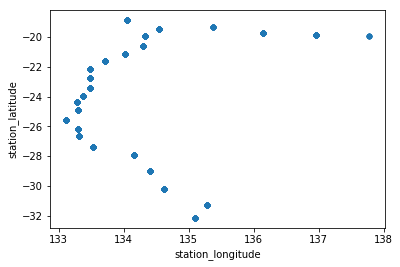

In [14]:
plt.figure(); pdf2.plot.scatter(x='station_longitude', y='station_latitude')

In [15]:
 med = pdf2.groupby(by=['source_block', 'station_block'])[
        'observed_tt'].quantile(q=.5, interpolation='lower').reset_index()

In [16]:
med.head()

,source_block,station_block,observed_tt
0,543424,626937,205.740091
1,1378415,647095,680.498927
2,1401344,637018,777.797851
3,1401344,639897,778.094573
4,1401344,647095,778.522459


In [48]:
med.shape

(841, 3)

In [50]:
med2 = pdf2.groupby(
        by=['source_block', 'station_block'] )['SNR'].max().reset_index() # use a seq index:0,1,2,.

In [52]:
med2.head()

,source_block,station_block,SNR
0,543424,626937,7.199925
1,1378415,647095,4.268246
2,1401344,637018,4.523065
3,1401344,639897,4.783324
4,1401344,647095,5.139861


In [54]:
med2.shape

(841, 3)

In [18]:
pdf2.shape

(1455, 14)

In [19]:
pdf3=pdf2.groupby(by=['source_block', 'station_block']).count()

In [20]:
pdf3.shape

(841, 12)

In [21]:
pdf4=pdf3[(pdf3['residual']>2)]

In [22]:
pdf4.shape

(0, 12)

In [23]:
pdf4.tail()

,,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
source_block,station_block,,,,,,,,,,,,


In [24]:
# select rows
rowmask= (pdf2['source_block'] == 9344) & (pdf2['station_block']==9037)  #select certain rows
pdf5=pdf2.loc[ rowmask ]

In [25]:
pdf5.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S


In [26]:
rowmask = (pdf2['source_block'] ==149425) & (pdf2['station_block']==18461)  #select rows where cond
pdf2.loc[ rowmask ].head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S


In [27]:
unikpdf2=pdf2.drop_duplicates(subset=['source_block', 'station_block'], keep='first')

In [28]:
unikpdf2.shape

(841, 14)

In [29]:
pdf2.shape

(1455, 14)

#  Modify the sort function

In [58]:
import logging
import sys
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)

log =logging.getLogger()
log.info('Hello world!')


# def sort(output_file, sorted_file, residual_cutoff):
def sort2(output_file, sorted_file, residual_cutoff):
    """
    Sort and filter the arrivals.

    Sort based on the source and station block number.
    There are two stages of filtering:
    1. Filter based on the time residual
    2. Filter based on best Signal_to_Noise-Ratio seismic wave: If there are multiple source and station block combinations, we keep the
    row corresponding to the highest SNR value

    cmdline usage:
    cluster sort outfile_P.csv 5. -s sorted_P.csv
    cluster sort outfile_S.csv 10. -s sorted_S.csv


    :param output_file: output file from the gather stage (eg, outfile_P.csv)
    :param sorted_file: str, optional
        optional sorted output file path. Default: sorted.csv.
    :param residual_cutoff: float
        residual seconds above which arrivals are rejected.
    :return: pandas_df
    """

    log.info('Filtering arrivals.')

    cluster_data = pd.read_csv(output_file, header=None,
                               names=column_names)
    
    cluster_data = cluster_data[abs(cluster_data['residual'])
                                < residual_cutoff]
    
    cluster_data['source_depth'] = cluster_data['source_depth'] / 1000.0  # convert to KM?
    
    # groupby sorts by default
    # cluster_data.sort_values(by=['source_block', 'station_block'],
    #                          inplace=True)

    log.info('Sorting arrivals.')

    # groupby automatically sorts
#     med = cluster_data.groupby(
#         by=['source_block', 'station_block']
#         )['observed_tt'].quantile(q=.5, interpolation='lower').reset_index() # use a seq index:0,1,2,....

#  SNR value max
    med = cluster_data.groupby(
        by=['source_block', 'station_block']
        )['SNR'].max().reset_index() # use a seq index:0,1,2,.
    
    # med dataframe has three columns:  [source_block, station_block ,observed_tt]
    
    final_df = pd.merge(cluster_data, med, how='right',
                        on=['source_block', 'station_block', 'SNR'],
                        sort=True,
                        right_index=True)

    # Confirmed: drop_duplicates required due to possibly duplicated picks in
    #  the original engdahl events
    # refer: https://github.com/GeoscienceAustralia/passive-seismic/issues/51
    # The subset is specified as we have some stations that are very close?
    final_df.drop_duplicates(subset=['source_block', 'station_block'],
                             keep='first',  inplace=True)

    final_df.to_csv(sorted_file, header=False, index=False, sep=',')
    
    return final_df

In [60]:
mypdf2 = sort2(inputcsv,sortedfile,residual_cutoff)

In [62]:
mypdf2.shape

(841, 14)

In [63]:
mypdf2.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
28,543424,626937,-4.594806,7000,135.7820,-4.3010,4.9,134.0455,-18.8731,205.740091,14.670456,BL06,7.199925,1
25,1378415,647095,0.050000,5000,83.5160,30.8390,10.0,133.4898,-22.1527,680.498927,71.449337,BL11,4.268246,1
798,1401344,637018,0.600000,102000,55.8332,26.7723,12.0,134.2961,-20.5914,777.315861,89.499655,BL08,4.523065,1
799,1401344,639897,0.700000,102000,55.8332,26.7723,12.0,134.0250,-21.1143,777.561630,89.531882,BL09,4.783324,1
800,1401344,647095,0.750000,102000,55.8332,26.7723,12.0,133.4898,-22.1527,777.937657,89.603853,BL11,5.784889,1


In [31]:
mypdf = sort2(inputcsv,sortedfile,residual_cutoff)

In [32]:
mypdf.shape

(841, 14)

In [33]:
mypdf.head()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
28,543424,626937,-4.594806,7000,135.782,-4.301,4900.0,134.0455,-18.8731,205.740091,14.670456,BL06,7.199925,1
25,1378415,647095,0.050000,5000,83.516,30.839,10000.0,133.4898,-22.1527,680.498927,71.449337,BL11,4.268246,1
1757,1401344,637018,0.950000,231000,55.814,26.804,12000.0,134.2961,-20.5914,777.797851,89.528001,BL08,4.523065,1
1758,1401344,639897,1.100000,231000,55.814,26.804,12000.0,134.0250,-21.1143,778.094573,89.560453,BL09,4.783324,1
1759,1401344,647095,1.200000,231000,55.814,26.804,12000.0,133.4898,-22.1527,778.522459,89.632859,BL11,5.139861,1


In [34]:
# check if any duplicate (source_block,station_block) in the dataframe?  primkey
mypdf3=mypdf.groupby(by=['source_block', 'station_block']).count()

In [35]:
mypdf3.head()

residual  event_number  source_longitude  \
source_block station_block                                             
543424       626937                1             1                 1   
1378415      647095                1             1                 1   
1401344      637018                1             1                 1   
             639897                1             1                 1   
             647095                1             1                 1   

                            source_latitude  source_depth  station_longitude  \
source_block station_block                                                     
543424       626937                       1             1                  1   
1378415      647095                       1             1                  1   
1401344      637018                       1             1                  1   
             639897                       1             1                  1   
             647095                       1             1                  1   

                            station_latitude  observed_tt  locations2degrees  \
source_block station_block                                                     
543424       626937                        1            1                  1   
1378415      647095                        1            1                  1   
1401344      637018                        1            1                  1   
             639897                        1            1                  1   
             647095                        1            1                  1   

                            station_code  SNR  P_or_S  
source_block station_block                             
543424       626937                    1    1       1  
1378415      647095                    1    1       1  
1401344      637018                    1    1       1  
             639897                    1    1       1  
             647095                    1    1       1

In [36]:
mypdf4 = mypdf3[(mypdf3['residual']>1)]

In [37]:
# check if any duplicate (source_block,station_block)
mypdf4.shape  # no rows now  


(0, 12)

In [38]:
pdf2.loc[2]

source_block           1378415
station_block           647095
residual             0.0499996
event_number              5000
source_longitude        83.516
source_latitude         30.839
source_depth             10000
station_longitude       133.49
station_latitude      -22.1527
observed_tt            680.499
locations2degrees      71.4493
station_code              BL11
SNR                    4.26825
P_or_S                       1
Name: 2, dtype: object

In [39]:
pdf2.iloc[1]

source_block          543424
station_block         626937
residual            -4.59481
event_number          171000
source_longitude     135.782
source_latitude       -4.301
source_depth            4900
station_longitude    134.046
station_latitude    -18.8731
observed_tt           205.74
locations2degrees    14.6705
station_code            BL06
SNR                  7.19992
P_or_S                     1
Name: 1, dtype: object

In [40]:
pdf2.describe()

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,SNR,P_or_S
count,1.455000e+03,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.000000,1455.0
mean,2.122692e+07,657124.637801,0.133579,114696.907216,39.621849,-5.640275,199298.457113,134.040589,-23.980667,422.317732,39.529013,12.636316,1.0
std,2.014550e+07,20782.562491,1.898514,69173.939683,146.792066,20.583684,193910.844772,0.929494,3.582858,130.369280,16.981754,23.152381,0.0
min,5.434240e+05,626937.000000,-4.977433,2000.000000,-179.927200,-42.273000,4900.000000,133.111100,-32.146000,166.210173,12.050276,1.856297,1.0
25%,4.839131e+06,637018.000000,-1.185357,52000.000000,-177.538000,-19.863000,43100.000000,133.367700,-26.671800,322.950435,25.769206,4.976747,1.0
50%,1.281793e+07,657174.000000,0.318299,105000.000000,126.161000,-8.368000,115300.000000,133.712800,-23.929900,429.520272,39.866534,6.728480,1.0
75%,2.858323e+07,673014.000000,1.650000,172000.000000,145.691000,1.889000,272300.000000,134.330100,-20.591400,475.891778,44.976974,10.168939,1.0
max,6.594265e+07,704701.000000,4.150000,241000.000000,179.920500,51.952000,634700.000000,137.781500,-18.873100,779.562631,89.912268,331.442255,1.0


In [41]:
pdf2.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454],
           dtype='int64', length=1455)

In [42]:
pdf2.index=pdf2.event_number

In [43]:
pdf2.index

Int64Index([  7000, 171000,   5000, 177000, 231000, 237000, 231000, 237000,
            231000, 237000,
            ...
             83000,  85000,  83000,  85000,  60000, 221000,  60000, 221000,
             60000, 221000],
           dtype='int64', name='event_number', length=1455)

In [44]:
pdf2.tail(n=5)

,source_block,station_block,residual,event_number,source_longitude,source_latitude,source_depth,station_longitude,station_latitude,observed_tt,locations2degrees,station_code,SNR,P_or_S
event_number,,,,,,,,,,,,,,
221000,65942646,631259,-2.45,221000,-178.645,-18.235,634700.0,134.5445,-19.4320,431.846438,44.182980,BL05,5.145639,1
60000,65942646,634138,1.30,60000,-178.645,-18.235,634700.0,134.3301,-19.9213,436.719426,44.330221,BL07,4.220760,1
221000,65942646,634138,1.30,221000,-178.645,-18.235,634700.0,134.3301,-19.9213,436.719426,44.330221,BL07,4.220760,1
60000,65942646,649975,1.85,60000,-178.645,-18.235,634700.0,133.4806,-22.7386,441.490709,44.886271,BL12,4.723372,1
221000,65942646,649975,1.85,221000,-178.645,-18.235,634700.0,133.4806,-22.7386,441.490709,44.886271,BL12,4.723372,1


In [45]:
pdf2.iloc[1]  # now .loc[2] does not work

source_block          543424
station_block         626937
residual            -4.59481
event_number          171000
source_longitude     135.782
source_latitude       -4.301
source_depth            4900
station_longitude    134.046
station_latitude    -18.8731
observed_tt           205.74
locations2degrees    14.6705
station_code            BL06
SNR                  7.19992
P_or_S                     1
Name: 171000, dtype: object

In [47]:
#pdf2.loc[215]